## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(random_state=42),
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((425, 23), (183, 23))

In [8]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	10
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	10
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	10
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	10
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	5
Rejected: 	11
I

BorutaPy(estimator=RandomForestClassifier(n_estimators=46,
                                          random_state=RandomState(MT19937) at 0x2A058F33340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2A058F33340, verbose=2)

In [9]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'ERCsContrastbaseline', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((425, 8), (183, 8))

## TPE

In [15]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
    
    ngb_n_estimators = trial.suggest_int("ngb_n_estimators", 200, 500)
    ngb_learning_rate = trial.suggest_float("ngb_learning_rate", 0.01, 0.1, log=True)    
    model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                              n_estimators=ngb_n_estimators,
                              learning_rate=ngb_learning_rate,
                              verbose=False) 

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [16]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-03-16 17:21:35,899] A new study created in memory with name: no-name-f7233872-dc35-496e-933e-6119e4b41f9f
[I 2025-03-16 17:22:03,313] Trial 0 finished with value: 0.5412576312576312 and parameters: {'ngb_n_estimators': 221, 'ngb_learning_rate': 0.017100851082669045}. Best is trial 0 with value: 0.5412576312576312.
[I 2025-03-16 17:22:45,467] Trial 1 finished with value: 0.5411385836385836 and parameters: {'ngb_n_estimators': 358, 'ngb_learning_rate': 0.0113068751815281}. Best is trial 0 with value: 0.5412576312576312.
[I 2025-03-16 17:23:12,517] Trial 2 finished with value: 0.5536752136752137 and parameters: {'ngb_n_estimators': 202, 'ngb_learning_rate': 0.09486038106911292}. Best is trial 2 with value: 0.5536752136752137.
[I 2025-03-16 17:24:01,072] Trial 3 finished with value: 0.5447100122100123 and parameters: {'ngb_n_estimators': 410, 'ngb_learning_rate': 0.011978517297479684}. Best is trial 2 with value: 0.5536752136752137.
[I 2025-03-16 17:24:31,241] Trial 4 finished with

In [17]:
study.best_params

{'ngb_n_estimators': 256, 'ngb_learning_rate': 0.056545401318693914}

In [18]:
study.best_value

0.5654426129426129

In [19]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_ngb_learning_rate,params_ngb_n_estimators,state
0,0,0.541258,2025-03-16 17:21:35.901962,2025-03-16 17:22:03.313845,0 days 00:00:27.411883,0.017101,221,COMPLETE
1,1,0.541139,2025-03-16 17:22:03.313845,2025-03-16 17:22:45.467105,0 days 00:00:42.153260,0.011307,358,COMPLETE
2,2,0.553675,2025-03-16 17:22:45.467105,2025-03-16 17:23:12.517985,0 days 00:00:27.050880,0.094860,202,COMPLETE
3,3,0.544710,2025-03-16 17:23:12.537331,2025-03-16 17:24:01.072067,0 days 00:00:48.534736,0.011979,410,COMPLETE
4,4,0.553120,2025-03-16 17:24:01.072067,2025-03-16 17:24:31.241675,0 days 00:00:30.169608,0.062609,235,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_12212\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


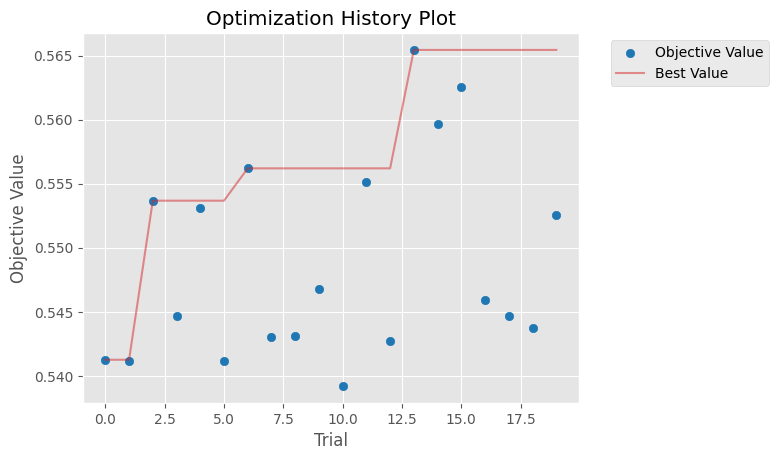

In [20]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_12212\3449611284.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='ngb_learning_rate', ylabel='Objective Value'>,
       <Axes: xlabel='ngb_n_estimators'>], dtype=object)

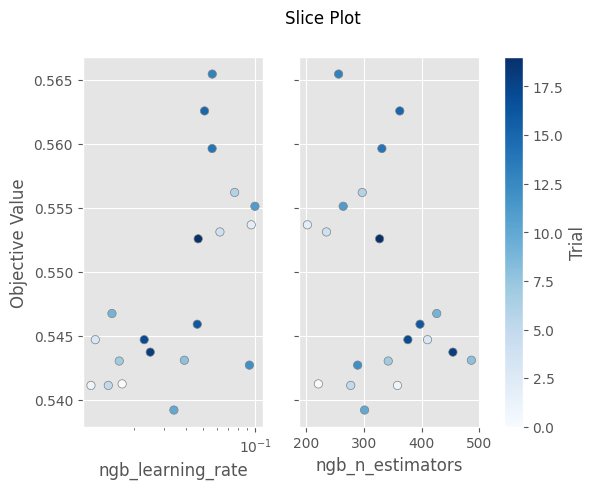

In [22]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["ngb_n_estimators", "ngb_learning_rate"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_12212\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

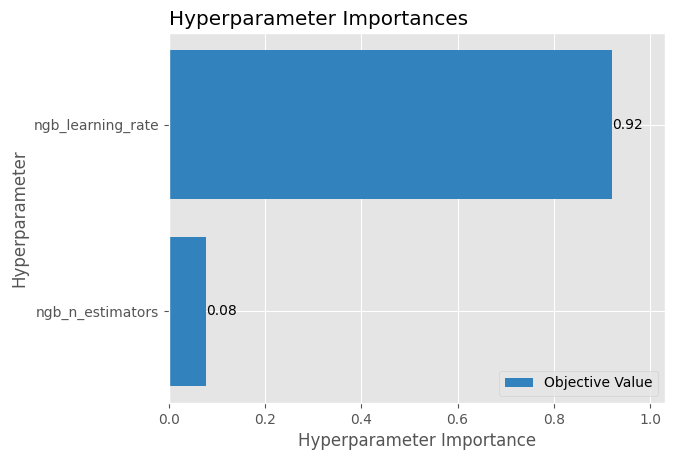

In [23]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_12212\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

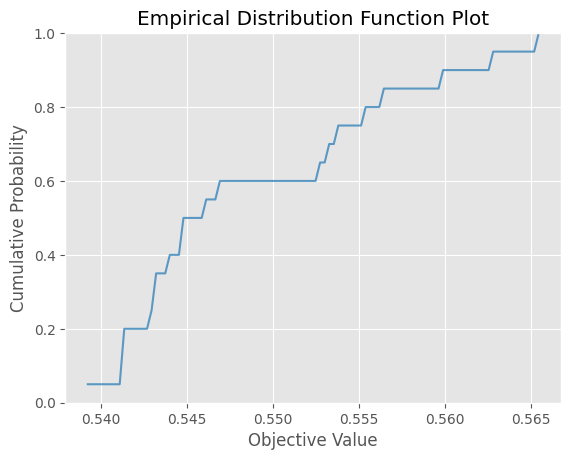

In [24]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [27]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                        n_estimators=study.best_params['ngb_n_estimators'],
                        learning_rate=study.best_params['ngb_learning_rate'], 
                        random_state=42
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [28]:
trained_ngb_n, metrics_ngb_n = run_model("NGBoost", "Complete", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", "Boruta", X_train_t, y_train)

[iter 0] loss=1.3184 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.4468 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.4468 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=1.3184 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.4633 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.4633 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=1.3184 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.4790 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.4790 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=1.3156 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.4582 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.4582 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=1.3156 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.4569 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.4569 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=1.3177 val_loss=0.0000 scale=4.0000 

In [29]:
validation_df = pd.concat([metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
NGBoost    balanced_accuracy Complete          4.770    23                   0.729   
                             Boruta            4.459    8                    0.685   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          4.770    23                  0.019   
                             Boruta            4.459    8                   0.015   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          4.770    23                  0.580   
                             Boruta            4.459    8                   0.566   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
NGBoost    balanced_accuracy Complete          4.770    23                 0.063  
                             Boruta            4.459    8                  0.055

In [30]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [31]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                             
Boruta            NGBoost    1.508               23             accuracy                   0.776   
                                                                balanced_accuracy          0.707   
                                                                precision                  0.776   
                                                                recall                     0.776   
                                                                f1_weighted                0.760   
                                                                roc_auc_ovr_weighted       0.957   
                             0.983               8              accuracy                   0.758   
                                                                balanced_accuracy          0.671   
                                                                precision                  0.771   
                                                                recall                     0.758   
                                                                f1_weighted                0.730   
                                                                roc_auc_ovr_weighted       0.943   

                                                                                      Test data  
Feature Selection Classifier Classification Time Total Features Metric                           
Boruta            NGBoost    1.508               23             accuracy                  0.596  
                                                                balanced_accuracy         0.581  
                                                                precision                 0.593  
                                                                recall                    0.596  
                                                                f1_weighted               0.562  
                                                                roc_auc_ovr_weighted      0.823  
                             0.983               8              accuracy                  0.601  
                                                                balanced_accuracy         0.586  
                                                                precision                 0.590  
                                                                recall                    0.601  
                                                                f1_weighted               0.565  
                                                                roc_auc_ovr_weighted      0.822

### Export model

In [33]:
trained_ngb_t

NGBClassifier(learning_rate=0.056545401318693914, n_estimators=256,
              random_state=RandomState(MT19937) at 0x2A02B925740)

In [34]:
import pickle

# Save the trained model using pickle
with open("ngboost_model.pkl", "wb") as file:
    pickle.dump(trained_ngb_t, file)

print("NGBoost model saved successfully!")

NGBoost model saved successfully!


In [ ]:
# Load the saved model using pickle
with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)